This project focuses on the house price prediction competition on Kaggle. We use the Multi - Layer Perceptron (MLP) model in deep learning and implement it with the PyTorch framework. It's well - known that for non - time - series house price prediction tasks with limited data, the prediction performance of deep learning models usually lags far behind that of traditional machine learning methods.

However, the core objective of this project is not to achieve high prediction accuracy but to provide a valuable opportunity for practice and learning. We firmly adhere to the concept of "learning through practice", enabling participants to gain in - depth understanding and mastery of relevant technologies during this process.

If you have any questions about this project or have unique suggestions for improvement, please feel free to communicate with us. We look forward to exploring and progressing together with you!

Competition link: [house-prices-advanced-regression](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

In [15]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

# 1.Set Up GPU

In [16]:
# 检查并设置设备：优先使用GPU（CUDA），如果没有则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 打印当前使用的设备信息
print(f"Using device: {device}")

Using device: cuda:0


# 2.Data Processing

## 2.1.Loading Dataset

In [17]:
# 读取训练数据和测试数据
# 使用pandas的read_csv函数从指定路径加载CSV文件
train_data = pd.read_csv(r'./data/house-prices/train.csv')  # 加载训练数据集
test_data = pd.read_csv(r'./data/house-prices/test.csv')    # 加载测试数据集

# 打印训练数据和测试数据的形状（行数和列数）
# shape属性返回一个元组，格式为(行数, 列数)
print(train_data.shape, test_data.shape)

(1460, 81) (1459, 80)


## 2.2.Data Clean

In [18]:
# 将训练集(除第一列ID和最后一列标签)和测试集(除第一列ID)的特征数据合并
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 筛选出数值型特征列(非object类型)
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 对数值特征进行标准化处理：(x - 均值)/标准差
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
# 用0填充标准化后可能产生的缺失值(NaN)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# 对类别型特征进行one-hot编码，dummy_na=True表示也会为缺失值创建指示列
all_features = pd.get_dummies(all_features, dummy_na=True)

## 2.3.Convert Data Types

In [19]:
# 获取训练集样本数量
n_train = train_data.shape[0]   

# 将前n_train行数据转换为PyTorch张量作为训练特征
# all_features是包含所有特征(训练+测试)的DataFrame
# 转换为numpy数组后再转为torch.float32类型的张量
train_features = torch.tensor(all_features[:n_train].to_numpy(dtype=np.float32), dtype=torch.float32)

# 将剩余数据转换为PyTorch张量作为测试特征
test_features = torch.tensor(all_features[n_train:].to_numpy(dtype=np.float32), dtype=torch.float32)

# 将训练集的房价(SalePrice)转换为PyTorch张量
# view(-1, 1)将一维数组转换为二维张量，形状为[n_samples, 1]
train_labels = torch.tensor(train_data.SalePrice.to_numpy(dtype=np.float32), dtype=torch.float32).view(-1, 1)

## 2.4.Create DataLoader

In [20]:
# 创建训练数据集TensorDataset对象，将特征和标签组合在一起
train_dataset = TensorDataset(train_features, train_labels)

# 创建训练数据加载器DataLoader
train_loader = DataLoader(
    dataset=train_dataset,  # 指定训练数据集
    batch_size=128,        # 设置批量大小为128
    shuffle=True,          # 每个epoch打乱数据顺序
    pin_memory=True       # 启用内存固定(加速GPU数据传输)
)

# 3.Construct A Model

## 3.1.Construct A MLP

In [21]:
class HousePriceModel(nn.Module):
    def __init__(self, input_size):
        """房价预测模型 (MLP网络结构)
        
        参数:
            input_size: 输入特征的维度大小
        """
        super().__init__()
        self.net = nn.Sequential(
            # 第一层全连接层: input_size -> 256
            nn.Linear(input_size, 256),
            nn.ReLU(),  # ReLU激活函数
            
            # 第二层全连接层: 256 -> 128 
            nn.Linear(256, 128),
            nn.ReLU(),
            
            # 第三层全连接层: 128 -> 64
            nn.Linear(128, 64),
            nn.ReLU(),
            
            # 第四层全连接层: 64 -> 32
            nn.Linear(64, 32),
            nn.ReLU(),
            
            # 输出层: 32 -> 1 (输出房价预测值)
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        """前向传播
        
        参数:
            x: 输入特征张量
        返回:
            房价预测值
        """
        return self.net(x)

In [22]:
# 创建房屋价格预测模型实例，输入维度为训练特征的列数
# 并将模型移动到指定设备(CPU/GPU)
model = HousePriceModel(train_features.shape[1]).to(device)

# 打印模型结构，显示网络层和参数信息
print(model)

HousePriceModel(
  (net): Sequential(
    (0): Linear(in_features=330, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


## 3.2.Construct An Iterator And A Loss Function

In [23]:
# 定义损失函数 - 使用均方误差(MSE)作为评估指标
criterion = nn.MSELoss()

# 定义优化器 - 使用Adam优化算法，学习率设为0.02
optimizer = optim.Adam(model.parameters(), lr = 0.02)

# 4.Training Loop

## 4.1.Training

In [24]:
# 设置训练轮数为1000
epochs = 1000
# 将模型设置为训练模式
model.train()
# 初始化一个列表来保存每轮的训练损失
train_losses = []

# 开始训练循环
for epoch in range(epochs):
    epoch_loss = 0.0  # 初始化当前epoch的损失
    
    # 遍历训练数据加载器中的每个batch
    for batch_features, batch_labels in train_loader:
        # 将特征和标签移动到指定设备(如GPU)
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        # 前向传播：计算模型输出
        outputs = model(batch_features)
        # 计算损失
        loss = criterion(outputs, batch_labels)
        
        # 反向传播和优化
        optimizer.zero_grad()  # 清空梯度
        loss.backward()        # 反向传播计算梯度
        optimizer.step()       # 更新模型参数
        
        # 累加当前batch的损失
        epoch_loss += loss.item()
    
    # 计算并保存当前epoch的平均损失
    train_losses.append(epoch_loss / len(train_loader))
    
    # 每20个epoch打印一次训练信息
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

Epoch [20/1000], Loss: 362752738.6667
Epoch [40/1000], Loss: 165280366.0000
Epoch [60/1000], Loss: 105259408.0000
Epoch [80/1000], Loss: 83517063.3333
Epoch [100/1000], Loss: 49101049.5000
Epoch [120/1000], Loss: 38814403.8333
Epoch [140/1000], Loss: 39290777.0000
Epoch [160/1000], Loss: 25655695.4167
Epoch [180/1000], Loss: 32849485.5000
Epoch [200/1000], Loss: 32347750.6667
Epoch [220/1000], Loss: 17902183.5833
Epoch [240/1000], Loss: 11404892.3750
Epoch [260/1000], Loss: 23814412.6667
Epoch [280/1000], Loss: 41598400.8333
Epoch [300/1000], Loss: 6045105.9583
Epoch [320/1000], Loss: 25491186.0833
Epoch [340/1000], Loss: 6210134.6875
Epoch [360/1000], Loss: 66542815.3333
Epoch [380/1000], Loss: 4217583.7917
Epoch [400/1000], Loss: 6208492.0417
Epoch [420/1000], Loss: 8383025.7500
Epoch [440/1000], Loss: 10780233.9167
Epoch [460/1000], Loss: 64635926.8333
Epoch [480/1000], Loss: 5882827.8333
Epoch [500/1000], Loss: 10983640.6250
Epoch [520/1000], Loss: 8110817.1667
Epoch [540/1000], Lo

## 4.2.Result Visualization

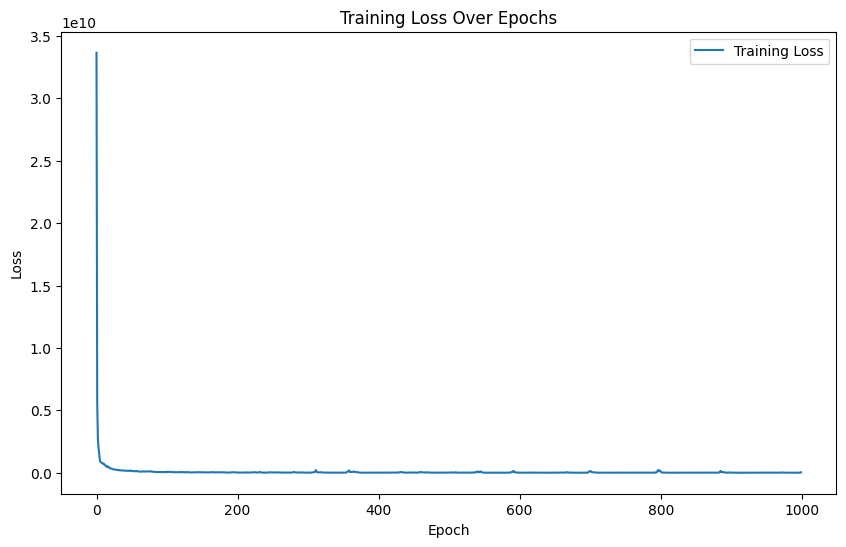

In [25]:
# 创建一个10x6英寸大小的图形
plt.figure(figsize=(10, 6))

# 绘制训练损失曲线，并添加标签
plt.plot(train_losses, label='Training Loss')

# 设置图表标题和坐标轴标签
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 显示图形
plt.show()

## 4.3.Model Evaluation

In [26]:
# 将模型设置为评估模式（关闭dropout等训练专用层）
model.eval()

# 禁用梯度计算以提升推理效率
with torch.no_grad():
    # 将测试特征数据移动到GPU设备（如果可用）
    test_features = test_features.to(device)
    
    # 进行预测：将数据传入模型 -> 转回CPU -> 转为numpy数组 -> 去除多余维度
    predictions = model(test_features).cpu().numpy().squeeze()

# 5.Generate A Submission File

In [27]:
# 创建一个DataFrame用于提交预测结果
# 创建包含ID和预测房价的两列数据
submission = pd.DataFrame({
    'Id': test_data['Id'],        # 使用测试数据中的ID列
    'SalePrice': predictions      # 使用模型预测的房价结果
})

# 将DataFrame保存为CSV文件，不保存行索引
submission.to_csv('submission.csv', index=False)

# 打印保存成功信息
print("Submission saved!")

Submission saved!


# 6.Clear GPU Cache

In [28]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()